In [19]:
import pandas as pd

# Import Dataset
parcel_data = pd.read_csv('../data/cleaned/fy2023-property-assessment-data-cleaned.csv')

In [20]:
from sklearn.model_selection import train_test_split

# assuming the data is in a dataframe named 'parcel_data'
X = parcel_data.drop(['TOTAL_VALUE'], axis=1)
y = parcel_data['TOTAL_VALUE']

# Split the data into training and test sets (30% held out for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Define categorical pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Define categorical and numerical features
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

linear_reg = LinearRegression()

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_reg)
])
pipe.fit(X_train, y_train)

# Evaluate the model on the test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = pipe.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

Categorical columns are: ['CITY', 'LU', 'LU_DESC', 'BLDG_TYPE', 'OWN_OCC', 'STRUCTURE_CLASS', 'ROOF_STRUCTURE', 'ROOF_COVER', 'EXT_FNISHED', 'INT_COND', 'EXT_COND', 'OVERALL_COND', 'BDRM_COND', 'KITCHEN_TYPE', 'HEAT_TYPE', 'HEAT_FUEL', 'AC_TYPE', 'ORIENTATION', 'PROP_VIEW', 'CORNER_UNIT']
Numerical columns are: ['ZIP_CODE', 'LUC', 'LAND_SF', 'GROSS_AREA', 'YR_BUILT', 'YR_REMODEL', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'KITCHENS', 'TT_RMS', 'FIREPLACES', 'NUM_PARKING']
MAE: 6638360.359326619
RMSE: 343480911.6438231
R2: -360.3581518767431


In [26]:
from sklearn.feature_selection import SelectPercentile, r_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

# Define the pipeline for polynomial regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selectpercentile', SelectPercentile(score_func=r_regression)),
    ('poly', PolynomialFeatures()),
    ('model', linear_reg)
])

# Define the hyperparameter grid to search over
param_grid = {
    'selectpercentile__percentile': np.logspace(.1, .5, 10),  # Percentiles of features to keep
    'poly__degree': [1, 2, 3],  # Degree of polynomials features
}

# Perform grid search using cross-validation to find the best hyperparameters
grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid, scoring='r2', verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END poly__degree=1, selectpercentile__percentile=1.2589254117941673; total time=   1.9s
[CV] END poly__degree=1, selectpercentile__percentile=1.2589254117941673; total time=   1.9s
[CV] END poly__degree=1, selectpercentile__percentile=1.2589254117941673; total time=   2.0s
[CV] END poly__degree=1, selectpercentile__percentile=1.2589254117941673; total time=   2.0s
[CV] END poly__degree=1, selectpercentile__percentile=1.2589254117941673; total time=   1.7s
[CV] END poly__degree=1, selectpercentile__percentile=1.3945832491957453; total time=   1.8s
[CV] END poly__degree=1, selectpercentile__percentile=1.3945832491957453; total time=   1.8s
[CV] END poly__degree=1, selectpercentile__percentile=1.3945832491957453; total time=   1.7s
[CV] END poly__degree=1, selectpercentile__percentile=1.3945832491957453; total time=   1.8s
[CV] END poly__degree=1, selectpercentile__percentile=1.3945832491957453; total time=   1.7s
[CV] END

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['CITY',
                                                                          'LU',
                                                                          'LU_DESC',
                                                                          'BLDG_TYPE',
                                                                          'OWN_OCC',
                                                                          'STRUCTURE_CLASS',
                                                                          'ROOF_STRUCTURE',
                                                                          'ROOF_COVER',
                                                                          'EXT_FNISHED',
                                                                          'IN...
                                       ('selectpercentile',
                                        SelectPercentile(score_func=<function r_regression at 0x13c0e7a30>)),
                                       ('poly', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3],
                         'selectpercentile__percentile': array([1.25892541, 1.39458325, 1.54485915, 1.7113283 , 1.89573565,
       2.10001416, 2.32630507, 2.57698037, 2.85466766, 3.16227766])},
             scoring='r2', verbose=2)

In [27]:
# Evaluate the best model on the validation set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = best_model.score(X_test, y_test)

# Print the results
print(f"Best feature percentile: {best_model.named_steps['selectpercentile'].percentile}")
print(f"Best polynomial degree: {best_model.named_steps['poly'].degree}")
print(f"Validation RMSE: {rmse}")
print(f"Validation R2: {r2}")

Best feature percentile: 2.576980374514878
Best polynomial degree: 1
Validation RMSE: 10044923.08814626
Validation R2: 0.6909520449802216


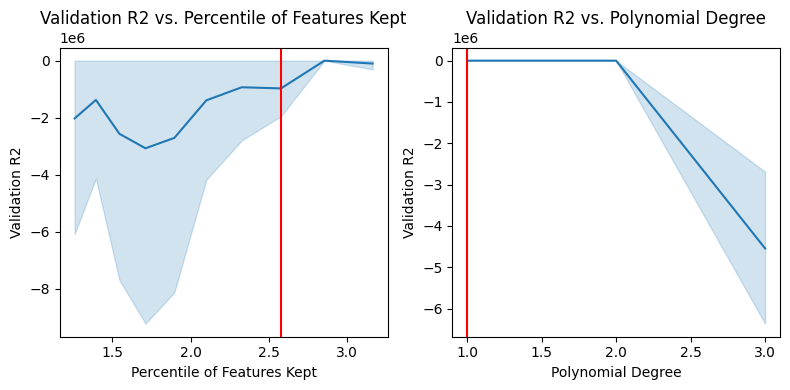

In [72]:
# Graph GridSearchCV results
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the results of the grid search
results = pd.DataFrame(grid.cv_results_)
results['percentile'] = results['param_selectpercentile__percentile'].astype(float)
results['degree'] = results['param_poly__degree'].astype(int)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.lineplot(x='percentile', y='mean_test_score', data=results, ax=ax[0])
sns.lineplot(x='degree', y='mean_test_score', data=results, ax=ax[1])
# Mark the best parameters
ax[0].axvline(best_model.named_steps['selectpercentile'].percentile, color='red')
ax[1].axvline(best_model.named_steps['poly'].degree, color='red')
ax[0].set_title('Validation R2 vs. Percentile of Features Kept')
ax[1].set_title('Validation R2 vs. Polynomial Degree')
ax[0].set_xlabel('Percentile of Features Kept')
ax[1].set_xlabel('Polynomial Degree')
ax[0].set_ylabel('Validation R2')
ax[1].set_ylabel('Validation R2')
fig.tight_layout()
plt.show()

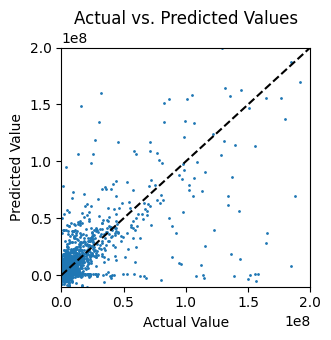

In [68]:
# Graph Model Results

# Plot the predicted values against the actual values
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.scatter(y_test, y_pred, s=1)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
ax.set_title('Actual vs. Predicted Values')
# Plot the line y=x
ax.plot([0, 1e9], [0, 1e9], ls='--', c='k')
# Set the x and y limits
ax.set_xlim(0, 2e8)
ax.set_ylim(-1e7, 2e8)
fig.tight_layout()
plt.show()

In [78]:
# Output the features selected by the model
features = best_model.named_steps['selectpercentile'].get_support()
# print count of features selected
print(f"Number of features selected: {features.sum()}")


Number of features selected: 14
